In [1]:
#        DATA
# ==================== #
import pandas as pd
import numpy as np
from scipy import stats
import time
import random
import math

#      PLOTING
# ============================== #
from PIL import Image
from IPython.core.display import HTML 

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="white")

#      TimeSeries
# ============================================================================== #
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf , pacf
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

#      Metrics
# ============================================================================== #
from sklearn.metrics import mean_squared_error , r2_score, max_error



#      OTHERS
# ============================== #
from sklearn.inspection import permutation_importance
import multiprocessing

from python.funcionesPropias import *

#      WARNINGS
# ============================== #
import warnings
warnings.filterwarnings("ignore")
import dill

In [2]:
lineasMetro = pd.read_csv('../metroAnalisis/data/lineasMetro.csv' , encoding= 'latin-1')

In [3]:
lineasMetro['Línea'] = lineasMetro.index
lineasMetro.fillna('-', inplace= True )
lineasMetro['Terminales'] = lineasMetro['Terminales'].apply(lambda x : '-'.join(x.split('\x96'))  if len(x.split('\x96')) >1 else x )
lineasMetro.drop(['Gálibo','Andén'], axis = 1, inplace= True)

# Motivación

El Metro de Madrid fué inagurado en $1919$ por el rey Alfonso XIII, aquella primera "red" de Metro constaba únicamente con ocho paradas, desde la Puerta del Sol hasta Cuatro Caminos. Tuvo tal éxito el nuevo medio de transporte en la ciudad que fué usado por más de 14 millones de usuarios.

Actualmente el Metro de Madrid, es la segunda red de metro mas extensa de la Unión Europea y la cuerta del mundo, consta de $13$ líneas con $278$ paradas distribuidas por toda la ciudad, creando una gran red de transporte de casi $290$km, estableciendo la red de transporte más eficiente de la capital.

In [4]:
display(lineasMetro.set_index('Línea'))
print('Tabla extraída de wikipedia')

,Terminales,Longitud,Estaciones
Línea,,,
0,Pinar de Chamartín - Valdecarros,"20,8 km",31
1,Las Rosas - Cuatro Caminos,14 km,20
2,Villaverde Alto - Moncloa,"16,4 km",18
3,Argüelles - Pinar de Chamartín,16 km,23
4,Alameda de Osuna - Casa de Campo,"23,2 km",32
5,Circular,"23,5 km",28
6,Hospital de Henares - Pitis,"31,2 km",29
7,Nuevos Ministerios - Aeropuerto T4,"16,5 km",8
8,Paco de Lucía - Arganda del Rey,"38,0 km",26


Tabla extraída de wikipedia


En la Comunidad de Madrid (CAM) el transporte público preferido por los Madrileños es el Metro y en los tiempos que nos encontramos (de pandemia), resultaría interesante estimar el volumen de pasajeros que recibirá el Metro en distintos instantes del tiempo.

Apoyados en la temperatura, viento, presión atmosférica y cantidad de rayoUV, vamos a intentar predecir la cantidad de viajeros en el metro de manera mensual (debido a que no he encontrado datos diarios, o incluso por horas).

In [5]:
df = pd.read_csv('./data/dfFinal.csv')
print(f"Tenemos {df.shape[1]} columnas y {df.shape[0]} filas")
df.drop(['mes_x', 'ano_x','mes_y', 'ano_y','festividad'], axis=1, inplace=True)

Tenemos 25 columnas y 396 filas


In [6]:
df.columns = ['fecha','volumenMetro', 'tmed', 'prec', 'tmin', 'tmax', 'dir',
       'velmedia', 'racha', 'presMax', 'presMin', 'tmedStd', 'precStd',
       'tminStd', 'tmaxStd', 'dirStd', 'velmediaStd', 'rachaStd', 'presMaxStd',
       'presMinStd']

df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')
df = df.set_index('fecha')
df = df.asfreq('MS')
df = df.sort_index()
df = df.query("'01/01/2000' < fecha < '01-01-2020'")
display(df.head()[['volumenMetro','tmed','prec','racha']])

,volumenMetro,tmed,prec,racha
fecha,,,,
2000-02-01,92.705,10.748276,5.448276,951.093103
2000-03-01,102.479,12.080645,6.777419,944.209677
2000-04-01,83.902,10.683333,6.273333,935.190000
2000-05-01,94.966,17.993750,12.743750,939.990323
2000-06-01,93.300,24.047917,16.800000,943.486667


Hemos recogido los datos desde Enero de $2000$ hasta Diciembre de $2019$ de volumen de pasajeros, datos climatológicos como temperatura, viento y presión medias y sus desviaciones típicas menusuales.
Los datos han sido extraidos del banco de datos del ayuntamiento de Madrid y de la AEMET.

Hemos tenido que realizar una imputación de algunos de los datos, pues había datos nulos de presión atmosférica. El método utilizado, al tratarse de una serie temporal, ha sido la interpolación que ofrece la librería pandas.

In [7]:
df = df.interpolate(method='time')

# Capítulo 1: Análisis explotatorio de los datos (EDA)

Lo primero que debemos hacer es un pequño análisis exploratorio de las variables input y de la variable objetivo. Decimos que una variable objetivo, cuando es la elegida para estimar y las variables input, son las que se basará nuestro modelo para realizar las predicciones. En nuestro conjunto de datos, tenemos diferenciadas tres tipos de variables.

Variable de tiempo(fecha), hasta el año $2020$ ya que debido a la pandemia, los datos se han visto alterados de manera muy fuerte y tener un frecuencia mensual, no tendríamos datos suficientes para hacer una buena estimación, es por esto, que se ha optado recurir a datos hasta el $2020$, también a tener en cuenta esta frecuencia mensual, esto se debe a que los datos que disponemos sobre el volumen de pasajeros en el metro de Madrid es mensual. En una puesta en producción los datos podrían ser en streaming, con una actualización de minutos, probablemente gestionado en un entorno spark o con un procesado en bach. Hemos propuesto una pequeña base de datos SQL con tres tablas, que contienen el maestro de fechas, donde determina si es laborable, festivo, fin de semana... Otra tabla con los datos meteorológicos, agrupados por la variable tiempo, aunque en la ciudad de Madrid, por ejemplo existen $3$ estaciones disponibles de donde sacar datos, estos datos los facilita la AEMET con su API y contiene un apartado para desarrolo de aplicaciones en streaming. Y por su puesto el volumen de pasajeros, que mediante los tornos ya instalados en las paradas de Metro se podría llevar el conteo casi en tiempo real. Por lo que, aunque la aplicación que propongo está gestionada en mensual, se podría extrapolar a un entorno en streaming o incluso para análisis en bach.

El modelo propuesto es un modelo ARIMA, ya que se ha comprobado en diversos estudios que para variables como la que vamos a estudiar tiene un gran rendimiento, además de su fácil interpretación. Además, al encontrarnos ante una serie temporal con carácter estacionario va el método clásico ARIMA tendrá un gran rendimiento.

## Volumen de pasajeros

Estos datos han sido extraidos de [Banco de datos del ayuntamiento de Madrid](http://www-2.munimadrid.es/CSE6/control/seleccionDatos?numSerie=15050100012) el dato viene informado miles de viajeros que están registrados en la agencia de viajeros de la CAM.

In [8]:
display(df.volumenMetro.describe().to_frame().T)

,count,mean,std,min,25%,50%,75%,max
volumenMetro,239.0,88.589019,12.173598,48.479,84.0535,91.535,96.3655,109.412


En el gráfico vemos como nos encontramos ante una serie casi en su totalidad estacionaria, hemos tenido que lidiar con una mala extracción de los datos, pues en el año $2010$ aparecía una gran caida de pasajeros. La decisión ha sido utilizar la media del año anterior y posterior, es decir, la media entre los datos de $2019$ y $2021$.

*Definición*: Decimos que un proceso estocástico es estarionario en el sentido estricto cuando las distribuciones marginales de cualquier conjunto de k variables son idénticas, en distribución y en parámetros.

Para nuestro estudio, nos vasta que el proceso sea estacionario en sentído débil, es decir
$$ \left\lbrace\begin{array}{l} \mu_t = \mu \ \ \forall t \\ \sigma_t^2 = \sigma^2 \ \ \forall t \\ Cov(X_t,X_{t+k}) = E[(x_t - \mu )(x_{t-k} - \mu)] = \gamma_k \ \ \forall k \end{array}\right.{ } $$

Esto quiere decir, que tanto media como varianza permanecen constantes con el tiempo y la covariancia, entre dos variables de la serie depende sólo de su separación en el tiempo.

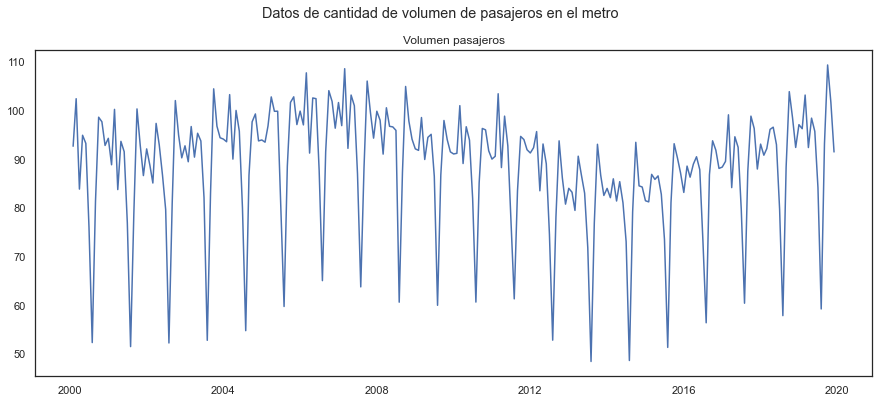

In [9]:
fig, (ax1) = plt.subplots(1,1,figsize=(15,6))
fig.suptitle("Datos de cantidad de volumen de pasajeros en el metro")
ax1.plot(df.volumenMetro)
ax1.set_title('Volumen pasajeros')
fig.show()

Vemos como la serie presenta una cierta periodicidad de los datos, pues la forma que toma la serie es similar en todo el tiempo. Presentando cierta tendencia sinusoidal, si queremos aplicar el modelo ARIMA, debemos "eliminar" esta componente estacional, mediante por ejemplo normalizando podríamos obtener un ruido blanco.

Decimos que un proceso estocástico es un ruido blanco si 

$$ E[X(t)] = 0 \ \ \ \ \ \ \ \ \ \  V[X(t)]=\sigma^2  \ \ \ \ \ \ \ \ \ \ \gamma_k=0 $$

El objetivo es ajustar el modelo ARIMA es que el error producido sea un ruido blanco, esto significará que nuestro modelo está bien ajustado.

Actualmente, vemos con un gráfico de cajas y bigotes y un histográma, que la distribución de nuestra serie no es simétrica y esto se debe a que aunque tenemos una periodicidad de los datos muy clara, existe tendencia, provocando que la distribución de la serie no sea simétrica, con una media distante a la mediana y una desviación tipìca elevada. Por lo que nuestra serie no es estacionaria.

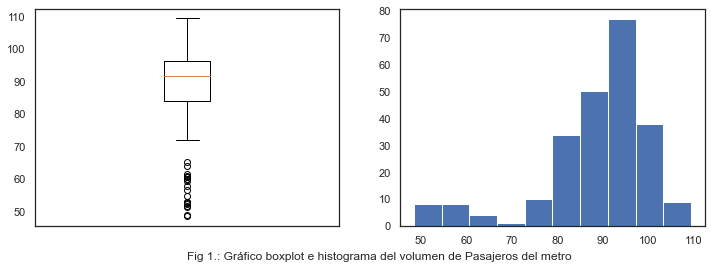

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.boxplot(df['volumenMetro'])
ax1.text(1,35, "Fig 1.: Gráfico boxplot e histograma del volumen de Pasajeros del metro")
ax1.set_xticklabels('')
ax2.hist(df['volumenMetro'])
fig.show()

## Variables climatológicas

Vamos a exponer la comparación de un par de series de la variable objetivo con alguna exogena de apoyo, aunque el estudio se ha realizado en todas las variables. Vamos a aplicar un filtro de fecha de 5 años para poder comprar mejor.

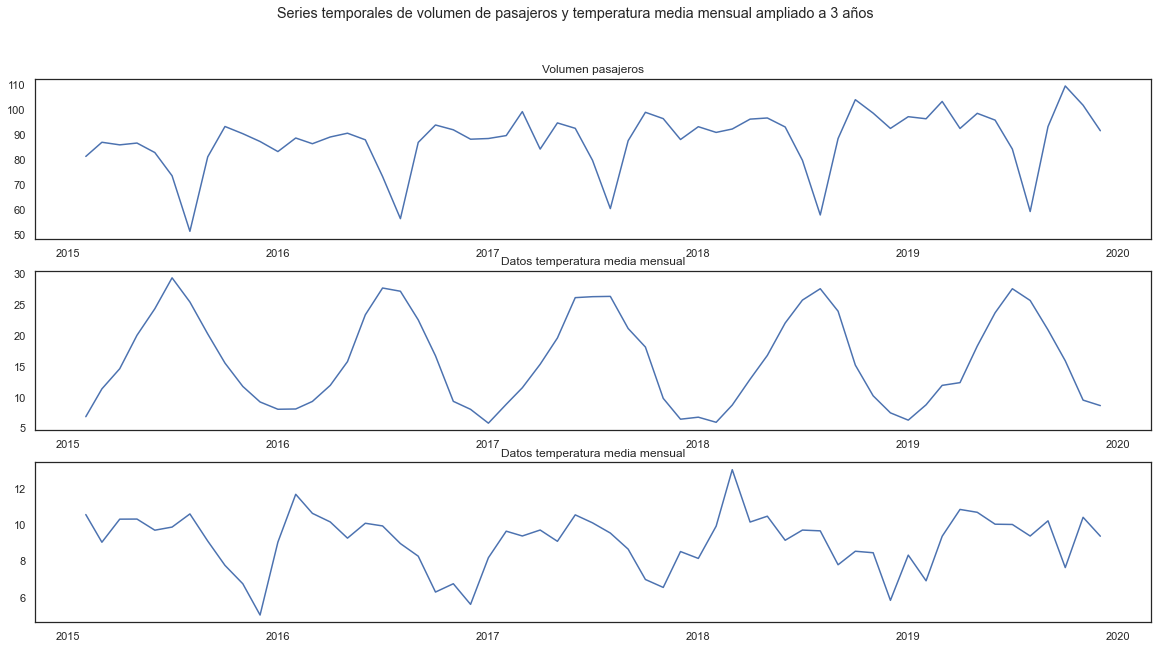

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,10))
fig.suptitle("Series temporales de volumen de pasajeros y temperatura media mensual ampliado a 3 años")
ax1.plot(pd.Series(df.query("fecha > '01-01-2015'").volumenMetro))
ax1.set_title('Volumen pasajeros')
ax2.plot(pd.Series(df.query("fecha > '01-01-2015'")['tmed']))
ax2.set_title("Datos temperatura media mensual")
ax3.plot(pd.Series(df.query("fecha > '01-01-2015'")['velmedia']))
ax3.set_title("Datos temperatura media mensual")
fig.show()

Vemos como claramente en las épocas de mas calor, hay menos usuarios de Metro que en los meses más fríos. Parece que la temperatura media puede ayudarnos a estimar. Si nos fijamos en el viento sin embargo, cuando se producen disminuciones en la valocidad del viento, vemos como en general, se producen los aumentos de volumen de pasajeros. Esto es debido a que parece que va con un ligero retraso en su periodicidad, ya que en julio/agosto se produce un aumento de la temperatura, con una disminución del volumen de pasajeros, pero el viento se mantiene constante para estos meses. Es a partir de septiembre cuando se produce esta disminución de la velocidad media del viento y una disminución de la temperatura y el aumento del volumen de pasajeros.

# Capítulo 2: Modelización predictiva

## Modelo ARIMA

Destacamos los modelos clásicos:
- Decimos que un modelo es AR(p) (Autoregresivo de orden p), cuando las autocorrelaciones simples decrecen de manera exponencial y existen p autocorrelaciones distintas de $0$.
- Decimos que un modelo es MA(q) (Medias móviles), cuando las autocorrelaciones simples decaen y se cortan de forma rápida, sin embargo las autocorrelaciones parciales decrecen exponencialmente.
- Decimos que un modelo es ARMA(p,q), cuando comparten las características de ambos modelos.

Definimos modelo ARIMA (Autoregresivo integrado de medias móviles), como el modelo estadístico que utiliza variaciones y regresiones de datos estadísticos con el fin de encontrar patrones para una predicción hacia el futuro. Como ya hemos explicado, las series estacionarias son las que tienen media $0$, por lo tanto, un proceso no estacionario lo llamaremos proceso integrado si al hacer una diferenciación se obtienen procesos estacionarios.


Decimos que aplicamos una diferenciación de orden k a una serie, cuando teniendo $X_t$ le restamos la observación de $k $ instantes anteriores, es decir,  $ X_{t-k} $.

Vamos a hacer una diferenciación de la serie para ver si conseguimos eliminar la media igual a cero y así poder aplicar un modelo $ARIMA(p,d,q)(P,D,Q)_s$.

Vamos a utilizar la metodología Box-Jenkis para ajustar el modelo lo más fielmente posible, para realizar unas buenas predicciones.

Esquema metodología Box-Jenkins


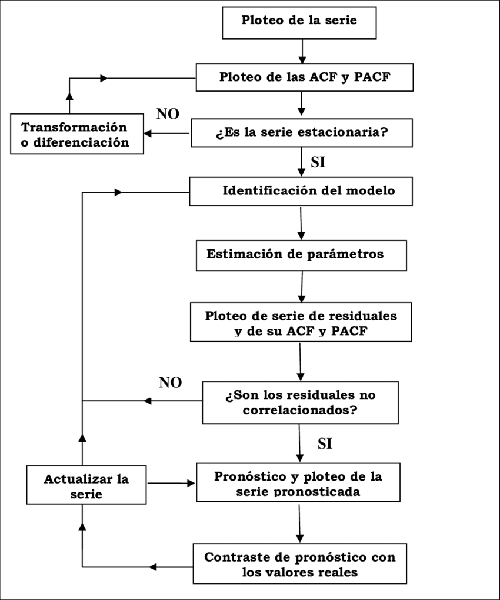

In [12]:
img = Image.open('./images/Figura-1-Metodologia-de-Box-Jenkins-para-el-analisis-de-series-de-tiempo (1).png')
print("Esquema metodología Box-Jenkins")
img.resize((500,600)) 

### Serie y descomposición estacional

Vamos a graficar la serie con su descomposición estacional, así podemos ver bien la tendencia, los coeficientes de estacionalidad y el error.

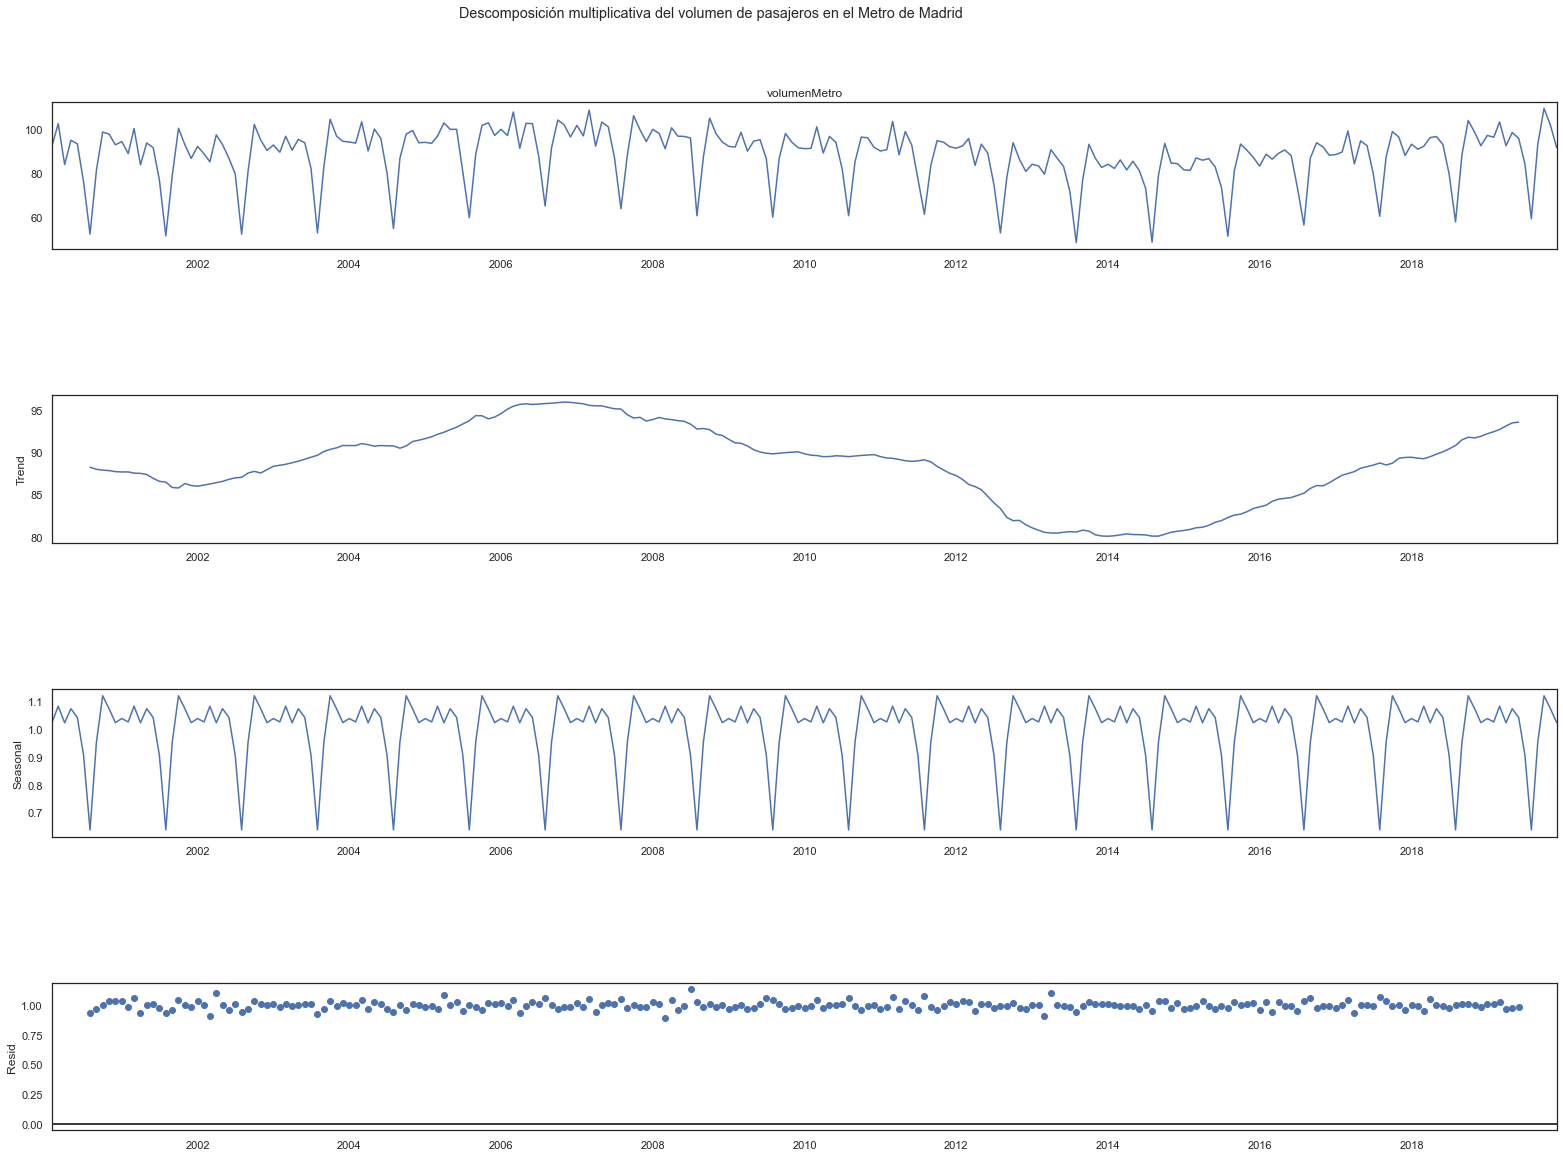

In [13]:
resultV=seasonal_decompose(df['volumenMetro'], model='multiplicable')
fig = resultV.plot()
fig.suptitle('Descomposición multiplicativa del volumen de pasajeros en el Metro de Madrid')
fig.set_size_inches(25, 18)
fig.show()

La serie ya hemos analizado que tiene una periodicidad de $12$ meses, esta descomposición nos afirma que efectivamente esto sucede. Además como habíamos percibido la tendencia tiene un comportamiento sinusoidal, esto nso indica que vamos a tener que aplicar una diferenciación con $12$ instantes anteriores. 
Si nos fijamos en la gráfica de la estacionalidad vemos como en el mes de julio/agosto se produce un decaimiento de más del $30 \%$ en el volumen de pasajeros y se alcanza un pico en el mes de septiembre con un aumento del $40 \%$ con respecto al instante anterior, lo que significa un aumento del $10 \%$ con respecto a la media.
Si nos fijamos en los residuos, estan en torno al $1$ con una variación pequeña.

Vamos a ver la serie diferenciada.

In [14]:
volDiff = df.volumenMetro.diff(1)

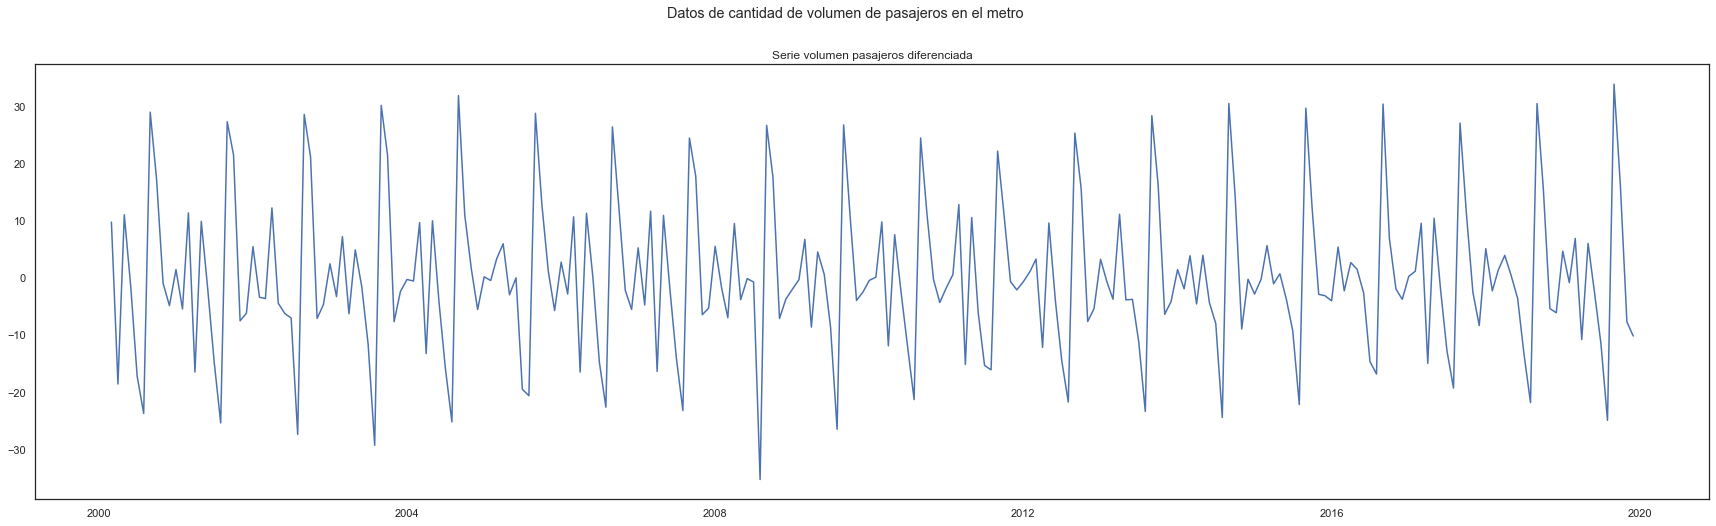

In [15]:
fig, (ax1) = plt.subplots(1,1,figsize=(30,8))
fig.suptitle("Datos de cantidad de volumen de pasajeros en el metro")
ax1.plot(volDiff)
ax1.set_title('Serie volumen pasajeros diferenciada')
fig.show()

Aplicando esta primera diferenciacion hemos centrado la media en $0$ por lo que hemos conseguido parte de las hipótesis para poder aplicar un modelo ARIMA. Pero vemos que sigue existendo periodicidad en la serie, esto se debe a que no hemos aplicado la diferenciación estacional. Vamos a aplicarle sobre esta diferenciación una diferenciación estacional de orden $12$ para ver si conseguimos eliminar este efecto periódico que presenta la serie.

In [16]:
volDiffEst = df.volumenMetro.diff(1).diff(12)
logVolDiffEst =  np.log(df.volumenMetro).diff(1).diff(12)

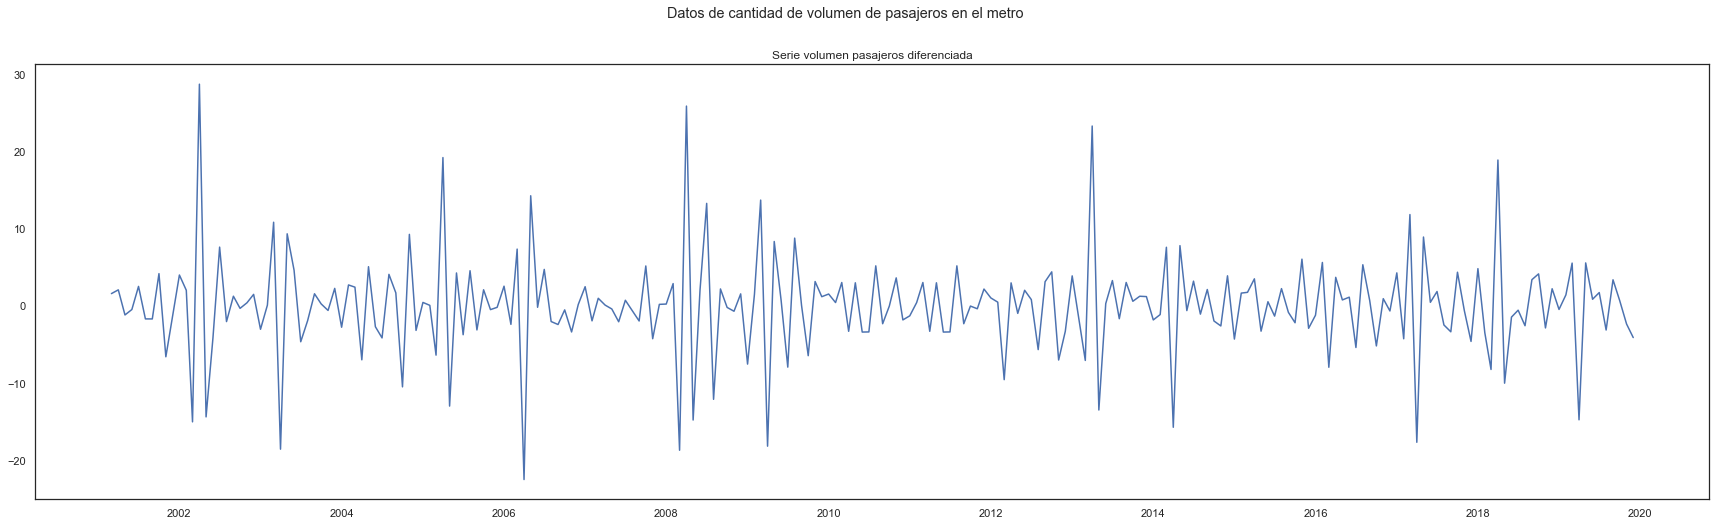

In [17]:
fig, (ax1) = plt.subplots(1,1,figsize=(30,8))
fig.suptitle("Datos de cantidad de volumen de pasajeros en el metro")
ax1.plot(volDiffEst)
ax1.set_title('Serie volumen pasajeros diferenciada')
fig.show()

Vemos como al aplicar esta segunda diferenciación de orden $12$ hemo eliminado la periodicidad de la serie. Parece que estamos ante unas buenas condiciones para aplicar el modelo, para estimar bien los parámetros del modelo ARIMA, necesitamos fijarnos en los autocorrelogramas de la serie ya diferenciada, pues es lo que nos indicará como estimar bien los parámetros para nuestro modelo ARIMA. 

Ya sabemos que tenemos que marcar la diferenciación de orden $1$ y de orden $12$ en la componente estacional.

In [18]:
VolDiffEst = df.volumenMetro.diff(1).diff(12).dropna()

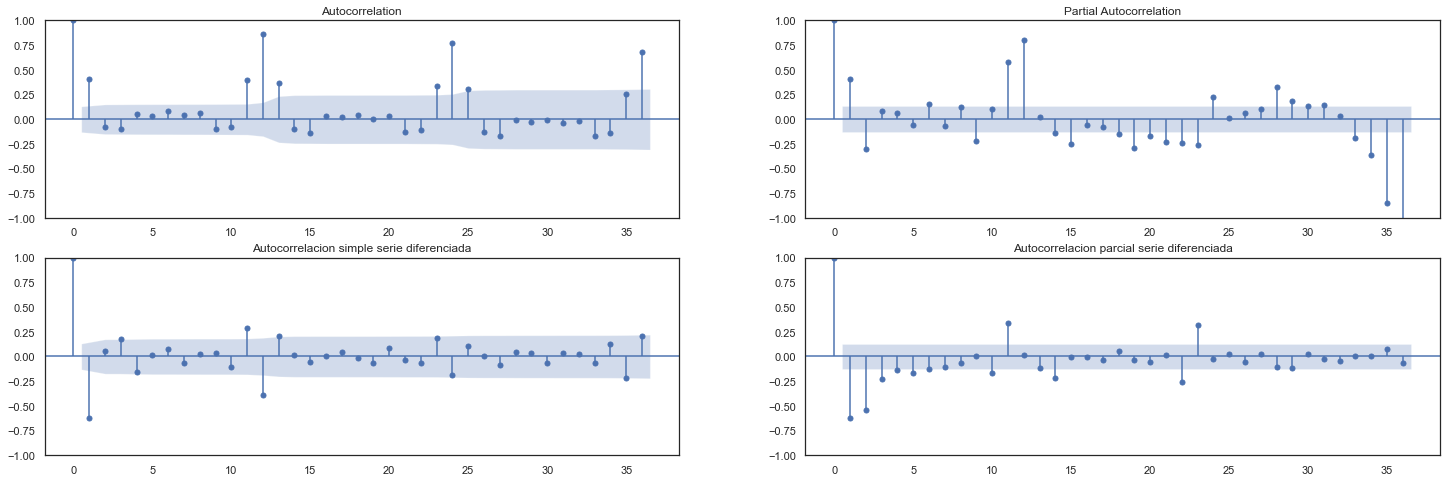

In [19]:
fig, ax = plt.subplots(2,2,figsize=(25,8))
ax[0,0] =plot_acf(df.query("fecha > '01-02-2001'").volumenMetro, lags= 36 , ax = ax[0,0], missing='drop')
ax[0,1] = plot_pacf(df.query("fecha > '01-02-2001'").volumenMetro, lags= 36, ax = ax[0,1])
ax[1,0] =plot_acf(VolDiffEst, lags= 36 , ax = ax[1,0], missing='drop' , title='Autocorrelacion simple serie diferenciada')
ax[1,1] = plot_pacf(VolDiffEst, lags= 36, ax = ax[1,1], title='Autocorrelacion parcial serie diferenciada')
fig.show()

Vemos como el aplicar logaritmos y diferenciar la serie, hemo eliminado practiamente la autocorrelación. Debemos corregir las autocorrelaciones que no hemos sido capaces de aproximar a $0$, eso lo conseguimos modelando los parámetros del ARIMA.

### Estamación de parámetros y representación de errores

Tendremos un primer modelo $ARIMA(4,1,0)(0,1,1)_{12}$, donde $(4,1,0)$ representa los $4$ autcorrelogramas que salen del parcial, el $1$ para representar la primera diferenciación. Y en la componente estacional tenemo un $(0,1,2)_12$ donde el $1$ se refiere a la diferenciación de orden $12$ (la estacional) y el $2$ la modelización de la autocorrelación de orden que aparece en el momento $12$ y en el $24$.

In [20]:
mod = ARIMA(df['volumenMetro'],order=(4, 1, 0) , seasonal_order=(0,1,2,12) , missing = 'raise')
res = mod.fit()
print(res.summary())

                                       SARIMAX Results                                       
Dep. Variable:                          volumenMetro   No. Observations:                  239
Model:             ARIMA(4, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood                -609.211
Date:                               Sun, 06 Feb 2022   AIC                           1232.422
Time:                                       13:30:24   BIC                           1256.365
Sample:                                   02-01-2000   HQIC                          1242.084
                                        - 12-01-2019                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9932      0.062    -15.940      0.000      -1.115      -0.871
ar.L2      

Vemos como el p-valor es $0.189$ para la componente autoregresiva y de $0.193$ para la parte de medias móviles, ambos mayores que $0.05$ pues podemos confirmar que se cumple la hipótesis de que los residuos están incorrelados. Debajo vemos como para el primer momento el autocorrelograma es 1 y después desciende en todos sus valores por debajo del intervalo de confianza, pues podemos asumirlos como $0$.

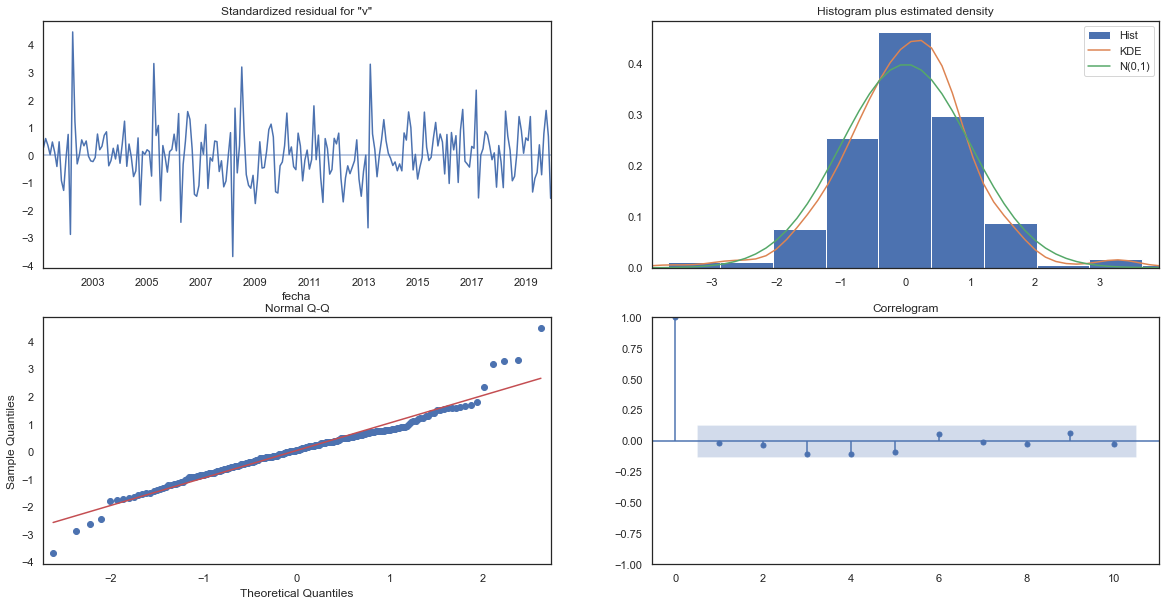

In [21]:
fig = res.plot_diagnostics(figsize=(20,10))
fig.show()

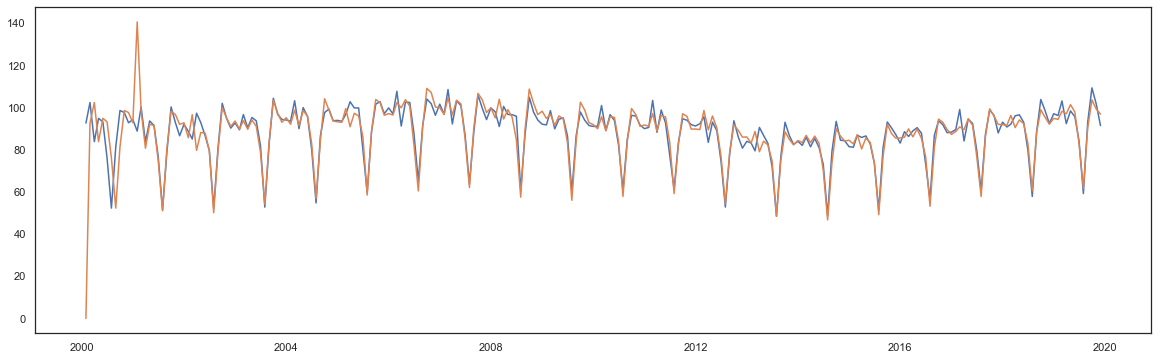

In [22]:
fig , ax1 = plt.subplots(1,1,figsize=(20,6))
ax1.plot(df['volumenMetro'])
ax1.plot(res.predict())
fig.show()

Vamos a realizar predicciones para 1, 5 y 12 meses, de tal forma que le aplicaremos un C-V de time series de 3 splits a cada una de las predicciones. Este C-V se trata de crear ventanas de tiempo que van cogiendo de menos a más conjunto de train y siempre guardan una ventana como test, para poder hacer la validación.

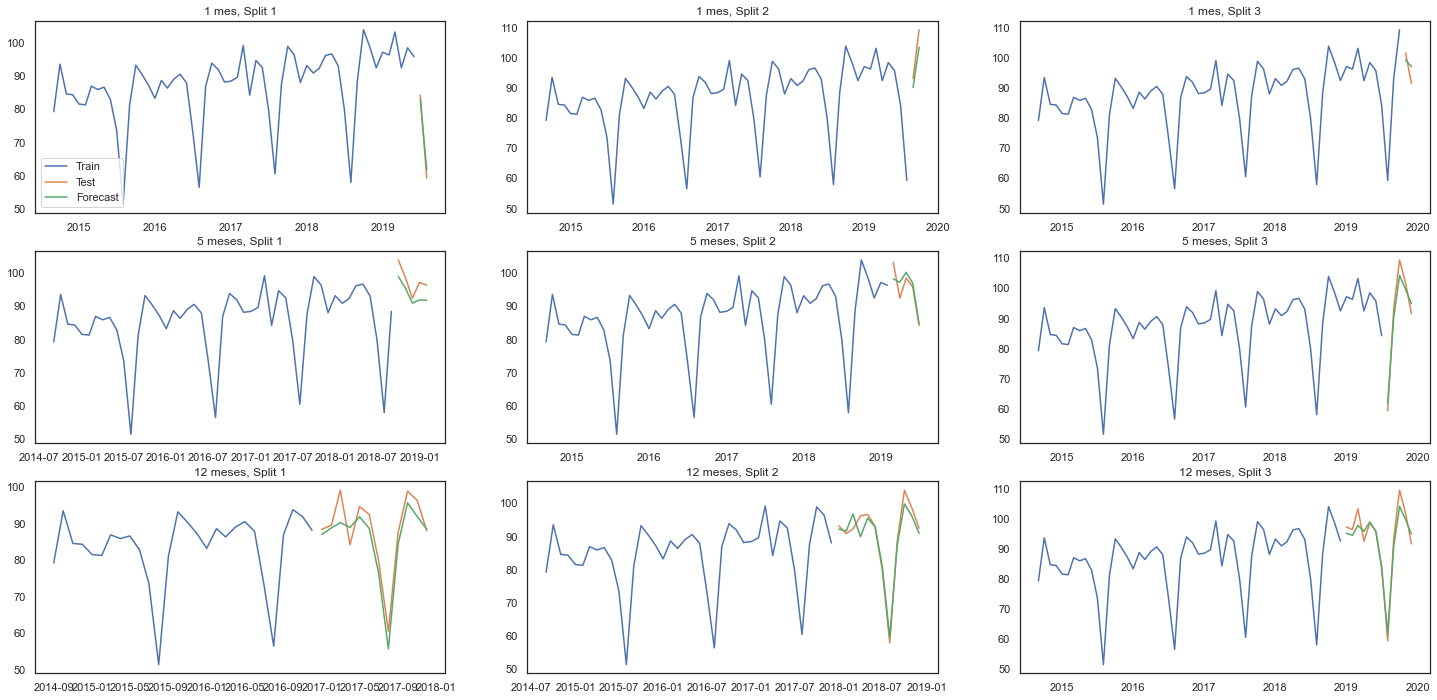

In [23]:
X = df.volumenMetro


fig , ax = plt.subplots(3,3,figsize = (25,12))
cont = 0
cont2 = 0
tss = TimeSeriesSplit(n_splits=3, test_size= 2)
for X_train, y_test in tss.split(X):
    mod = ARIMA(X[X_train] , order=(4, 1, 0) , seasonal_order=(0,1,2,12) , missing = 'raise')
    res = mod.fit()
    fore = res.forecast(len(y_test))

    ax[cont2%3,cont%3].plot(X[X_train].iloc[175:])
    ax[cont2%3,cont%3].plot(X[y_test])
    ax[cont2%3,cont%3].plot(fore)
    ax[cont2%3,cont%3].set_title(f'1 mes, Split {cont+1}')
    cont +=1
    if cont%3 == 0:
        cont2 +=1

tss = TimeSeriesSplit(n_splits=3, test_size= 5)
for X_train, y_test in tss.split(X):
    mod = ARIMA(X[X_train] , order=(4, 1, 0) , seasonal_order=(0,1,2,12) , missing = 'raise')
    res = mod.fit()
    fore = res.forecast(len(y_test))

    ax[cont2%3,cont%3].plot(X[X_train].iloc[175:])
    ax[cont2%3,cont%3].plot(X[y_test])
    ax[cont2%3,cont%3].plot(fore)
    ax[cont2%3,cont%3].set_title(f'5 meses, Split {cont%3+1}')
    cont +=1
    if cont%3 == 0:
        cont2 +=1

tss = TimeSeriesSplit(n_splits=3, test_size= 12)
for X_train, y_test in tss.split(X):
    mod = ARIMA(X[X_train] , order=(4, 1, 0) , seasonal_order=(0,1,2,12) , missing = 'raise')
    res = mod.fit()
    fore = res.forecast(len(y_test))

    ax[cont2%3,cont%3].plot(X[X_train].iloc[175:])
    ax[cont2%3,cont%3].plot(X[y_test])
    ax[cont2%3,cont%3].plot(fore)
    ax[cont2%3,cont%3].set_title(f'12 meses, Split {cont%3+1}')
    cont +=1
    if cont%3 == 0:
        cont2 +=1
ax[0,0].legend(['Train','Test','Forecast'])
fig.show()

En el gráfico vemos como la linea azul representa el conjunto de Train, si nos fijamos en los ejes para el primer split y para el resto, la serie temporal termina en distintos momentos, esto se debe a la variación del conjunto de train, como ya habíamos comentado. La lina naranja simpre es de la misma longitud, de 1, 5 y 12 meses en función de los que vayamos a predecir y la usamos como referencia para ver la calidad de nuestras predicciones. Y la verde representa a las predicciones que hace nuestro modelo. Como vemos, hay en ocasiones donde ajusta realmente bien y en otros momentos no es capaz de ajustarse tanto. Aunque parece a simple vista que la prediccion no es muy mala.

Si nos fijamos en la siguiente tabla, vemos los errores medios cometidos en cada una de las iteraciones por mes, en esta ocasion, hemos ejecutado el C-V con 15 splits para coger una media más real, ya que con solo 3 splits quizá no representa del todo bien la realidad.

In [24]:
modelos={}

maes = []
mses = []
rmses = []

tss = TimeSeriesSplit(n_splits=15, test_size= 1)
for X_train, y_test in tss.split(X):
    mod = ARIMA(X[X_train] , order=(4, 1, 0) , seasonal_order=(0,1,2,12) , missing = 'raise')
    res = mod.fit()
    fore = res.forecast(len(y_test))
    maes.append(max_error(X[y_test],fore))
    mses.append(mean_squared_error(X[y_test],fore))
    rmses.append(mean_squared_error(X[y_test],fore, squared=False))

modelos['arimaManual1mes'] =  {'MAE': np.array(maes),
                                'MSE': np.array(mses),
                                'RMSE': np.array(rmses)}


maes = []
mses = []
rmses = []


tss = TimeSeriesSplit(n_splits=15, test_size= 5)
for X_train, y_test in tss.split(X):
    mod = ARIMA(X[X_train] , order=(4, 1, 0) , seasonal_order=(0,1,2,12) , missing = 'raise')
    res = mod.fit()
    fore = res.forecast(len(y_test))
    maes.append(max_error(X[y_test],fore))
    mses.append(mean_squared_error(X[y_test],fore))
    rmses.append(mean_squared_error(X[y_test],fore, squared=False))

modelos['arimaManual5mes'] =  {'MAE': np.array(maes),
                                'MSE':np.array( mses),
                                'RMSE': np.array(rmses)}

maes = []
mses = []
rmses = []

tss = TimeSeriesSplit(n_splits=15, test_size= 12)
for X_train, y_test in tss.split(X):
    mod = ARIMA(X[X_train] , order=(4, 1, 0) , seasonal_order=(0,1,2,12) , missing = 'raise')
    res = mod.fit()
    fore = res.forecast(len(y_test))
    maes.append(max_error(X[y_test],fore))
    mses.append(mean_squared_error(X[y_test],fore))
    rmses.append(mean_squared_error(X[y_test],fore, squared=False))

modelos['arimaManual12mes'] =  {'MAE':np.array( maes),
                                'MSE': np.array(mses),
                                'RMSE': np.array(rmses)}

maes = []
mses = []
rmses = []

Vamos a analizar el MAE, MSE y RMSE, para las predicciones de $1$, $5$ y $12$ meses. Siendo $n$ el numero total de observaciones, $\hat{y_i}$ el valor predico e $y_i$ el valor observado en el instante $i$, donde $i=1,2,...,n$. Se tiene que:

El Error absoluto medio (MAE) viene dado por $ \frac{1}{n} \cdot \sum |\hat{y_i} - y_i)| $ con $i=1,...,n$

El Error cuadrático medio (MSE) viene dado por  $ \frac{1}{n} \cdot \sum (\hat{y_i} - y_i)^2 $ con $i=1,...,n $

El Raiz del error cuadrático medio (MSE) viene dado por  $\sqrt{ \frac{1}{n} \cdot \sum (\hat{y_i} - y_i)^2 }$ con $i=1,...,n $

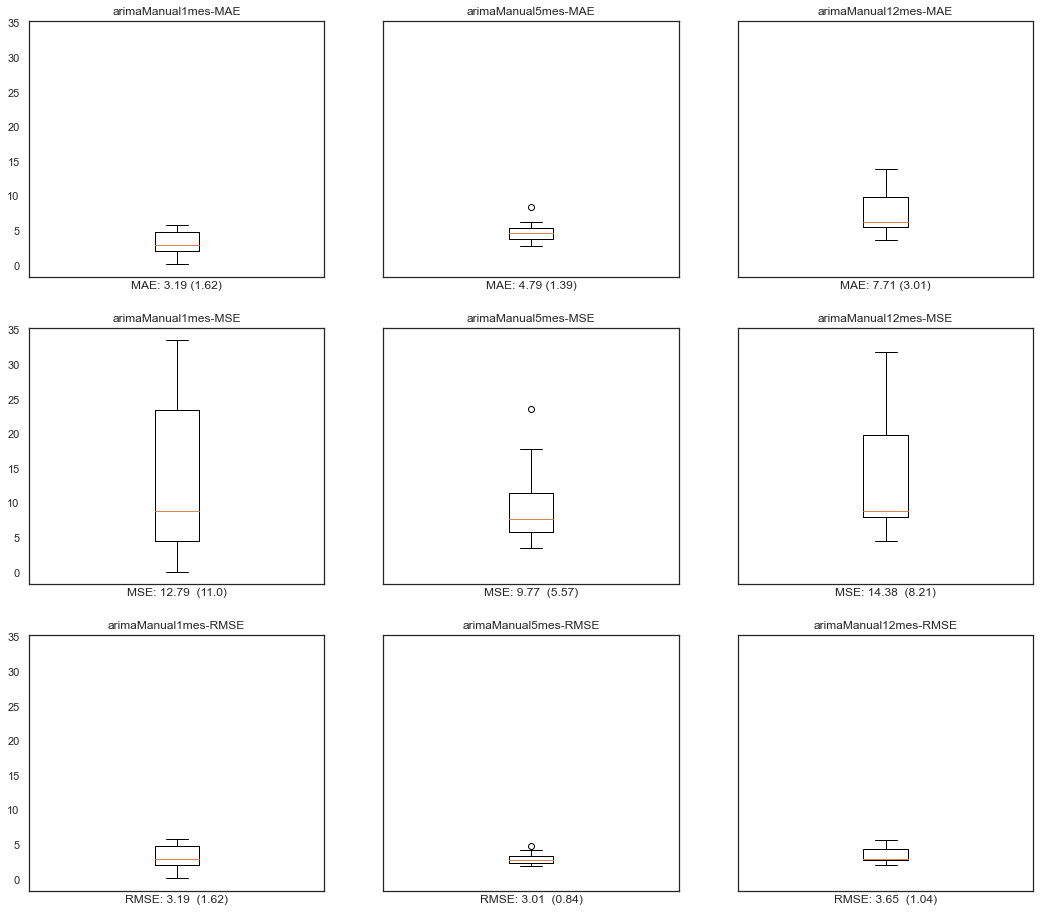

In [25]:
fig, ax = plt.subplots(3,3,figsize=(18,16) , sharey=True)
cont = 0
for name in list(modelos.keys()):
    for k,v in modelos[name].items():
        if k=='MAE':
            ax[0,cont].boxplot(v)
            ax[0,cont].set_xticks(ticks = [0], labels =[f"{name}-{k}"])
            ax[0,cont].set_xlabel(f"{k}: {round(v.mean(),2)} ({round(v.std(),2)})")
            ax[0,cont].set_title(f"{name}-{k}")
        elif k=='MSE':
            ax[1,cont].boxplot(v)
            ax[1,cont].set_xticks(ticks = [0], labels =[f"{name}-{k}"])
            ax[1,cont].set_xlabel(f"{k}: {round(v.mean(),2)}  ({round(v.std(),2)})")
            ax[1,cont].set_title(f"{name}-{k}")
        else:
            ax[2,cont].boxplot(v)
            ax[2,cont].set_xticks(ticks = [0], labels =[f"{name}-{k}"])
            ax[2,cont].set_xlabel(f"{k}: {round(v.mean(),2)}  ({round(v.std(),2)})")
            ax[2,cont].set_title(f"{name}-{k}")
    cont +=1
fig.show()

En el gráfico vemos la comparativa de los distintos errores por meses, además estamos mostrando el valor medio y la desviación estandar en cada uno de los gráficos.

Si analizamos los errores absolutos, el que mejor parado sale es la prediccion a un mes, tiene una media menor y además la desviación típica no es muy elevada. Sin embargo si nos fijamos en los errores cuadráticos, vemos como la mejor estimación es para 5 meses tanto en media como en varianza es el error más bajo. 
Parece que nuestro modelo estima mejor para $1$ y $5$ meses que para $12$, esto es algo lógico, pues cuando más tiempo queramos estimar, más error deberíamos cometer.

## Modelo AutoArima

Hemos realizado este mismo estudio con el modelo Autoarima que ofrece la librería pmdarima, la librería ofrece una funcion auto_arima, que itera sobre los distintos valores que pueden tomar los parámetros, mostrando cuál es el mejor modelo ARIMA para esta serie.

In [26]:
modelAuto = auto_arima(
			df['volumenMetro'],
			m=12,
			seasonal = True,
			error_action="ignore",
			suppress_warnings=True)

In [27]:
print((modelAuto.summary()))

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  239
Model:             SARIMAX(3, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -654.369
Date:                                 Sun, 06 Feb 2022   AIC                           1324.738
Time:                                         13:33:23   BIC                           1352.516
Sample:                                              0   HQIC                          1335.933
                                                 - 239                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2684      0.092     -2.932      0.003      -0.448      -0

En esta ocasión nos ha recomendado un modelo $ARIMA(3,1,1)(1,0,(1,2))_{12} $ esto quiere decir que ha producido raíces complejas en el modelo. El p-valor asociado a la parte estacional es mayor que $0.05$ por lo que podemos aceptar la hipótesis de que las autocorrelaciones son ruido blanco.

Vamos a guardar los errores como en el modelo que hemos propuesto manualmente, para posteriormente comprarlas.

In [28]:
maes = []
mses = []
rmses = []

tss = TimeSeriesSplit(n_splits=15, test_size= 2)
for X_train, y_test in tss.split(X):
    mod = ARIMA(X[X_train] , order=(3, 1, 1) , seasonal_order=(1,0,(1,2),12) , missing = 'raise')
    res = mod.fit()
    fore = res.forecast(len(y_test))
    maes.append(max_error(X[y_test],fore))
    mses.append(mean_squared_error(X[y_test],fore))
    rmses.append(mean_squared_error(X[y_test],fore, squared=False))

modelos['arimaAuto1mes'] =  {'MAE': np.array(maes),
                                'MSE': np.array(mses),
                                'RMSE': np.array(rmses)}


maes = []
mses = []
rmses = []


tss = TimeSeriesSplit(n_splits=15, test_size= 5)
for X_train, y_test in tss.split(X):
    mod = ARIMA(X[X_train] , order=(3, 1, 1) , seasonal_order=(1,0,(1,2),12) , missing = 'raise')
    res = mod.fit()
    fore = res.forecast(len(y_test))
    maes.append(max_error(X[y_test],fore))
    mses.append(mean_squared_error(X[y_test],fore))
    rmses.append(mean_squared_error(X[y_test],fore, squared=False))

modelos['arimaAuto5mes'] =  {'MAE': np.array(maes),
                                'MSE': np.array(mses),
                                'RMSE': np.array(rmses)}


maes = []
mses = []
rmses = []



tss = TimeSeriesSplit(n_splits=15, test_size= 12)
for X_train, y_test in tss.split(X):
    mod = ARIMA(X[X_train] ,  order=(3, 1, 1) , seasonal_order=(1,0,(1,2),12) , missing = 'raise')
    res = mod.fit()
    fore = res.forecast(len(y_test))
    maes.append(max_error(X[y_test],fore))
    mses.append(mean_squared_error(X[y_test],fore))
    rmses.append(mean_squared_error(X[y_test],fore, squared=False))

modelos['arimaAuto12mes'] =  {'MAE': np.array(maes),
                                'MSE': np.array(mses),
                                'RMSE': np.array(rmses)}


maes = []
mses = []
rmses = []


## Modelo ARIMA con variables exógenas

Vamos a utilizar el modelo autoarima de nuevo pero esta vez utilizaremos las variables exógenas para ver si podemos mejorar la calidad de nuestras predicciones.

In [31]:
exo = ['tmed','tmaxStd','velmediaStd']
modelAutoExo = auto_arima(
			df['volumenMetro'],
	        exogenous=df[exo],
			m=12,
			seasonal = True,
			error_action="ignore",
			suppress_warnings=True)

In [32]:
print((modelAutoExo.summary()))

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  239
Model:             SARIMAX(1, 1, 3)x(1, 0, [1, 2], 12)   Log Likelihood                -654.302
Date:                                 Sun, 06 Feb 2022   AIC                           1330.605
Time:                                         13:41:02   BIC                           1368.800
Sample:                                     02-01-2000   HQIC                          1345.998
                                          - 12-01-2019                                         
Covariance Type:                                   opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
tmed           -0.0051      0.154     -0.033      0.973      -0.308     

In [33]:
maes = []
mses = []
rmses = []

tss = TimeSeriesSplit(n_splits=15, test_size= 2)
for X_train, y_test in tss.split(df):
    mod = ARIMA(endog = df['volumenMetro'].iloc[X_train] ,exog=df[exo].iloc[X_train] , order=(1,1,3) , seasonal_order=(1,0,(1,2),12) , missing = 'raise')
    res = mod.fit()
    fore = res.forecast(len(y_test), exog=df[exo].iloc[y_test])
    maes.append(max_error(df['volumenMetro'].iloc[y_test],fore))
    mses.append(mean_squared_error(df['volumenMetro'].iloc[y_test],fore))
    rmses.append(mean_squared_error(df['volumenMetro'].iloc[y_test],fore, squared=False))

modelos['arimaAutoExo1mes'] =  {'MAE': np.array(maes),
                                'MSE': np.array(mses),
                                'RMSE': np.array(rmses)}


maes = []
mses = []
rmses = []


tss = TimeSeriesSplit(n_splits=15, test_size= 5)
for X_train, y_test in tss.split(X):
    mod = ARIMA(endog = df['volumenMetro'].iloc[X_train] ,exog=df[exo].iloc[X_train]  , order=(1,1,3) , seasonal_order=(1,0,(1,2),12) , missing = 'raise')
    res = mod.fit()
    fore = res.forecast(len(y_test), exog=df[exo].iloc[y_test])
    maes.append(max_error(df['volumenMetro'].iloc[y_test],fore))
    mses.append(mean_squared_error(df['volumenMetro'].iloc[y_test],fore))
    rmses.append(mean_squared_error(df['volumenMetro'].iloc[y_test],fore, squared=False))

modelos['arimaAutoExo5mes'] =  {'MAE': np.array(maes),
                                'MSE': np.array(mses),
                                'RMSE': np.array(rmses)}


maes = []
mses = []
rmses = []



tss = TimeSeriesSplit(n_splits=15, test_size= 12)
for X_train, y_test in tss.split(X):
    mod = ARIMA(endog = df['volumenMetro'].iloc[X_train] ,exog=df[exo].iloc[X_train]  , order=(1,1,3) , seasonal_order=(1,0,(1,2),12) , missing = 'raise')
    res = mod.fit()
    fore = res.forecast(len(y_test), exog=df[exo].iloc[y_test])
    maes.append(max_error(df['volumenMetro'].iloc[y_test],fore))
    mses.append(mean_squared_error(df['volumenMetro'].iloc[y_test],fore))
    rmses.append(mean_squared_error(df['volumenMetro'].iloc[y_test],fore, squared=False))

modelos['arimaAutoExo12mes'] =  {'MAE': np.array(maes),
                                'MSE': np.array(mses),
                                'RMSE': np.array(rmses)}


maes = []
mses = []
rmses = []


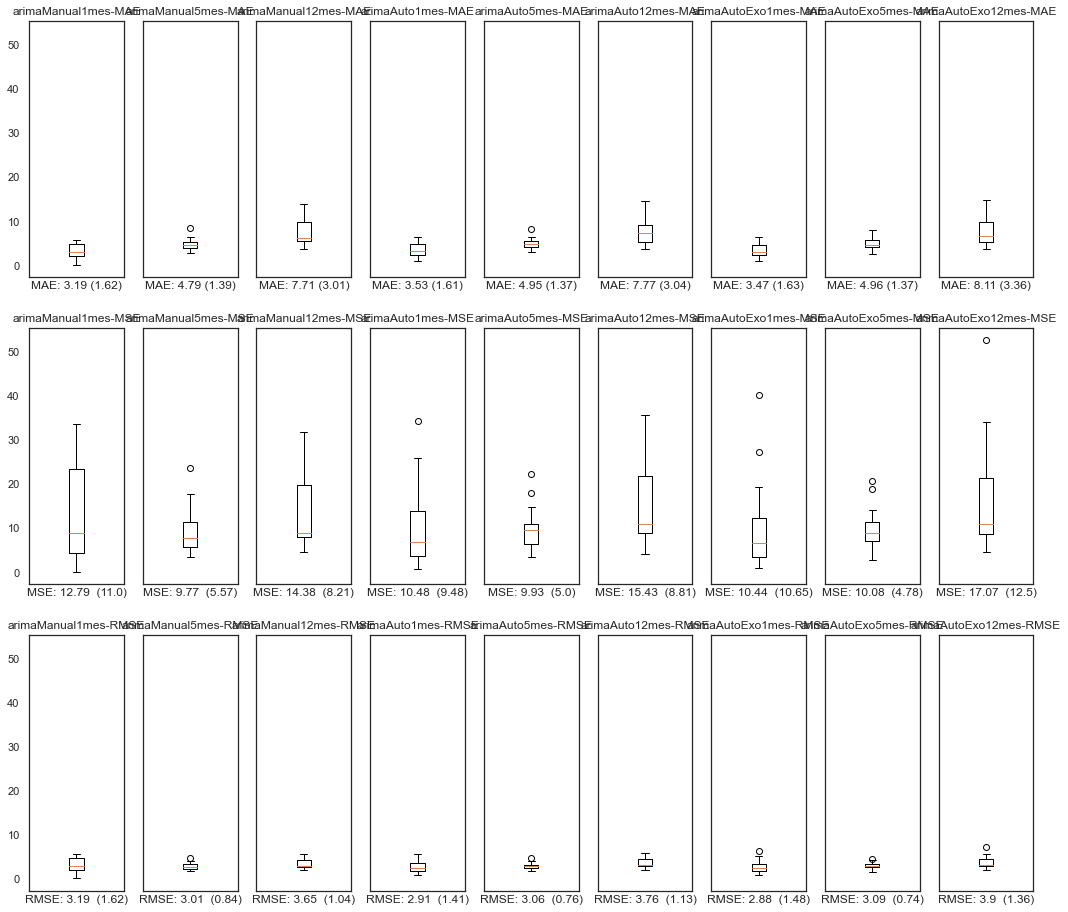

In [34]:
fig, ax = plt.subplots(3,9,figsize=(18,16) , sharey=True)
cont = 0
for name in list(modelos.keys()):
    for k,v in modelos[name].items():
        if k=='MAE':
            ax[0,cont].boxplot(v)
            ax[0,cont].set_xticks(ticks = [0], labels =[f"{name}-{k}"])
            ax[0,cont].set_xlabel(f"{k}: {round(v.mean(),2)} ({round(v.std(),2)})")
            ax[0,cont].set_title(f"{name}-{k}")
        elif k=='MSE':
            ax[1,cont].boxplot(v)
            ax[1,cont].set_xticks(ticks = [0], labels =[f"{name}-{k}"])
            ax[1,cont].set_xlabel(f"{k}: {round(v.mean(),2)}  ({round(v.std(),2)})")
            ax[1,cont].set_title(f"{name}-{k}")
        else:
            ax[2,cont].boxplot(v)
            ax[2,cont].set_xticks(ticks = [0], labels =[f"{name}-{k}"])
            ax[2,cont].set_xlabel(f"{k}: {round(v.mean(),2)}  ({round(v.std(),2)})")
            ax[2,cont].set_title(f"{name}-{k}")
    cont +=1
fig.show()

# Capítulo 3: Elección del modelo y puesta en producción

# Bibliografía

Treveil, M. & the Dataiku Team. (2020). Introducing MLOps (1.a ed., Vol. 1). O’Reilly.

Zheng, A., & Casari, A. (2018). Feature Engineering for Machine Learning: Principles and Techniques for Data Scientists. O’Reilly Media.

Hunter, J., Dale, D., Firing, E., Droettboom, M., & The Matplotlib development team. (2002-2021). Matplotlib. Matplotlib 3.5.1 documentation. 
    https://matplotlib.org/stable/index.html

Mauricio, J.A. (2007) Introducción al análisis de Series Temporales. UCM https://www.ucm.es/data/cont/docs/518-2013-11-11-JAM-IAST-Libro.pdf

Kutzkov, K. (2022, 4 enero). ARIMA vs Prophet vs LSTM for Time Series Prediction. Neptune.Ai. https://neptune.ai/blog/arima-vs-prophet-vs-lstm

pmdarima.arima.auto_arima — pmdarima 1.8.4 documentation. (2022). Pmandarina Documentation. https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

Introduction — statsmodels. (2022). StatsModels API. https://www.statsmodels.org/dev/index.html

In [ ]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

!jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True memoria.ipynb